# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

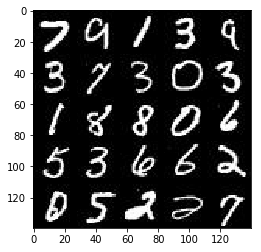

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

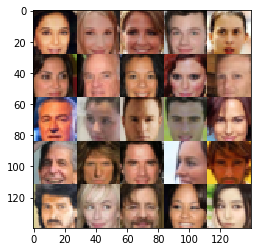

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # create real input images, z, and learning rate placeholders
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32)
    
    # :return tuple of (tensor of real input images, tensor of z data, learning rate)
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # as previous reviewer mentioned - https://www.reddit.com/r/MachineLearning/comments/36rd91/any_reason_behind_the_fact_that_the_filter_size/
    # i will implement this once I'm back from travel – 
    
    # convolution network with one fully connected layer at the end with sigmoid output
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28s28x(1[letters] or 3[faces])
        #kernel size is an integer or tuple of 2 integers spec the w&h of the 2d Conv window
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='valid')
        relu1 = tf.maximum(alpha * x1, x1)
        # Now 13x13x64
        
        # next layer - 6x6x128
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=3, strides=2, padding='valid') 
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
 
        # next layer - 3x3x256        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=2, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it and connect to a single sigmoid unit
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha=0.2
    #take the input and double it's size using strides of two & halving depth using transposed convolution
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,  3 * 3 * 512, activation=None)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        print(x1.shape)
        # shape now (?, 3, 3, 512)
        
        x2 = tf.layers.conv2d_transpose(
                                        x1,
                                        256,
                                        2,
                                        strides = 2,
                                        padding = 'valid'
                                        )
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        print(x2.shape)
        # shape now (?, 6, 6, 256)
        
        x3 = tf.layers.conv2d_transpose(x2,
                                        128,
                                        3,
                                        strides=2,
                                        padding='valid'
                                       )
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print(x3.shape)
        # shape now (?, 13, 13, 128)
        
        #end generator size should be the size of the image used so 28x28x3
        # no batch normalization on the final one
        logits = tf.layers.conv2d_transpose(x3,
                                            out_channel_dim,
                                            4,
                                            strides=2,
                                            padding='valid'
                                           )
        print(logits)
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("conv2d_transpose_6/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # keep getting error generator() got an unexpected keyword argument 'alpha' so deleted alpha from here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
      
    # calculate total loss
    d_loss = d_loss_real + d_loss_fake
    
    # return discriminator loss, generator loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1
                                            ).minimize(g_loss, var_list=g_vars)
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                        beta1=beta1
                                        ).minimize(d_loss,var_list=d_vars)
        
    # return discrimator training op & generator training op
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: use model_inputs, model_loss, & model_opt
    _, image_width, image_height, out_channel_dim = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # the values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 
                # dimensional images But the output from the tanh used in the generator gives an output 
                # between -1 and 1. Rescale the image accordingly
                image_input = 2 * batch_images
                steps += 1

                #sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={
                                                input_real: image_input,
                                                input_z: batch_z,
                                                lr: learning_rate
                                                })
                
                _ = sess.run(g_opt, feed_dict={
                                                input_real: image_input,
                                                input_z: batch_z,
                                                lr: learning_rate
                                              })
                _ = sess.run(g_opt, feed_dict={
                                                input_real: image_input,
                                                input_z: batch_z,
                                                lr: learning_rate
                                              })
                
                if steps & 10 == 0:
                    train_loss_d = d_loss.eval({
                                                input_z:batch_z,
                                                input_real: batch_images
                                               })
                    train_loss_g = g_loss.eval({
                                                input_z: batch_z
                                                })
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                    "Discriminator Loss: {:.4f}...".format(train_loss_d),
                    "Generator Loss: {:.4f}".format(train_loss_g))
                    
                #print the generator output every 100 batches.
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 3.9137... Generator Loss: 0.0287
Epoch 1/2... Discriminator Loss: 3.7163... Generator Loss: 0.0294
Epoch 1/2... Discriminator Loss: 3.7044... Generator Loss: 0.0303
Epoch 1/2... Discriminator Loss: 3.4536... Generator Loss: 0.0440
Epoch 1/2... Discriminator Loss: 3.4238... Generator Loss: 0.0442
Epoch 1/2... Discriminator Loss: 3.3891... Generator Loss: 0.0462
Epoch 1/2... Discriminator Loss: 3.3716... Generator Loss: 0.0455
Epoch 1/2... Discriminator Loss: 2.8560... Generator Loss: 0.0848
Epoch 1/2... Discriminator Loss: 2.8675... Generator Loss: 0.0887
Epoch 1/2... Discriminator Loss: 2.9922... Generator Loss: 0.0898
Epoch 1/2... Discriminator Loss: 2.9443... Generator Loss: 0.1044
Epoch 1/2... Discriminator Loss: 2.7958... Generator Loss: 0.1337
Epoch 1/2... Discriminator Loss: 2.8239... Generator Loss: 0.1406
Epoch 1/2

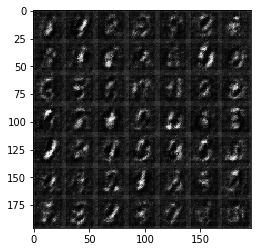

Epoch 1/2... Discriminator Loss: 1.9089... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.9680... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.9438... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 2.0286... Generator Loss: 0.5444
Epoch 1/2... Discriminator Loss: 2.0215... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 1.9935... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.9271... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.8230... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 1.8829... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.8423... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 1.8886... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.8562... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.9755... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 0.4773
Epoch 1/2.

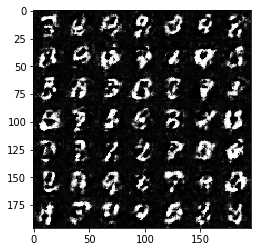

Epoch 1/2... Discriminator Loss: 1.8199... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.7891... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.7550... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.7786... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.7408... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.7701... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.7038... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.7670... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.7808... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 0.5242
Epoch 1/2.

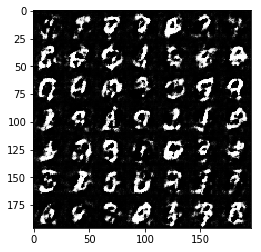

Epoch 1/2... Discriminator Loss: 1.7199... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.6436... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.7892... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.6522... Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 1.8922... Generator Loss: 1.1616
Epoch 1/2... Discriminator Loss: 1.6506... Generator Loss: 0.4867
Epoch 1/2... Discriminator Loss: 1.8712... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.8386... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 1.7005... Generator Loss: 0.6781
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 1.8030... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 1.8616... Generator Loss: 0.5118
Epoch 1/2... Discriminator Loss: 2.2773... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 1.8377... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 1.8845... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 1.8648... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 1.9050... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 2.1839... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.8071... Generator Loss: 0.4431
Epoch 1/2... Discriminator Loss: 1.9195... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.7621... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 2.0086... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.9084... Generator Loss: 0.4623
Epoch 1/2... Discriminator Loss: 2.3638... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.7839... Generator Loss: 0.4918
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 1.9628... Generator Loss: 0.4357
Epoch 1/2... Discriminator Loss: 2.0727... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 2.0688... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 2.2604... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.9476... Generator Loss: 0.3681
Epoch 1/2... Discriminator Loss: 2.0123... Generator Loss: 0.5892
Epoch 1/2... Discriminator Loss: 2.1288... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 2.0635... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 2.0800... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 2.1334... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.9089... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 2.0059... Generator Loss: 0.5705
Epoch 1/2... Discriminator Loss: 2.0222... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 2.1576... Generator Loss: 0.6907
Epoch 1/2.

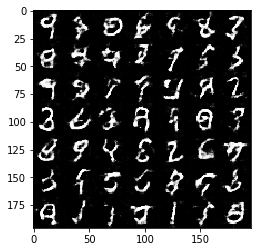

Epoch 1/2... Discriminator Loss: 2.1888... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 2.1128... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 2.1649... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.9925... Generator Loss: 0.2946
Epoch 1/2... Discriminator Loss: 2.0647... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 2.2090... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 2.0171... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 2.0521... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 2.2654... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 2.0599... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 2.1706... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.9375... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 2.2793... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 2.1495... Generator Loss: 0.2696
Epoch 1/2... Discriminator Loss: 1.9409... Generator Loss: 0.4452
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 2.0497... Generator Loss: 0.5238
Epoch 1/2... Discriminator Loss: 1.9632... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 2.2813... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.9215... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 2.1491... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 2.0073... Generator Loss: 0.3400
Epoch 1/2... Discriminator Loss: 2.1000... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 2.0834... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 2.1537... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 2.0452... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 2.2180... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 2.0009... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 2.4099... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 2.0101... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 2.1116... Generator Loss: 0.7093
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 2.0472... Generator Loss: 0.6474
Epoch 1/2... Discriminator Loss: 2.0266... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 2.2106... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 2.0643... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 2.1263... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 2.1303... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 2.0628... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 2.4388... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 2.1561... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 2.0329... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 2.2295... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 2.0140... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 1.9470... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 2.0235... Generator Loss: 0.4034
Epoch 1/2... Discriminator Loss: 2.1739... Generator Loss: 0.6784
Epoch 1/2.

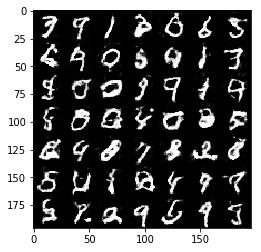

Epoch 1/2... Discriminator Loss: 1.9219... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 2.0092... Generator Loss: 0.4365
Epoch 1/2... Discriminator Loss: 2.1893... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.9681... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.9442... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 2.0075... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 2.0410... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 2.0851... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 2.4084... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 2.0261... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 1.7502... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 2.0845... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 2.4285... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 2.2904... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 2.0610... Generator Loss: 0.4372
Epoch 2/2.

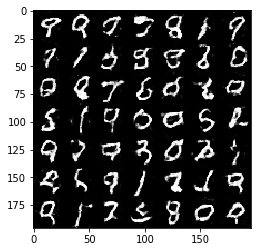

Epoch 2/2... Discriminator Loss: 2.3443... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 2.0537... Generator Loss: 0.5042
Epoch 2/2... Discriminator Loss: 2.0348... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 3.0257... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.9293... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 2.0124... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 2.3558... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 2.1117... Generator Loss: 0.6332
Epoch 2/2... Discriminator Loss: 2.3478... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 2.0306... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 2.0715... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 2.0664... Generator Loss: 0.2703
Epoch 2/2... Discriminator Loss: 1.7931... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 2.2027... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 2.1035... Generator Loss: 0.4119
Epoch 2/2.

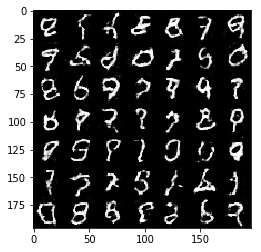

Epoch 2/2... Discriminator Loss: 1.9559... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.9200... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 2.2694... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 2.1281... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 2.2196... Generator Loss: 0.4639
Epoch 2/2... Discriminator Loss: 1.9983... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 2.2651... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 2.1230... Generator Loss: 0.3966
Epoch 2/2... Discriminator Loss: 2.3010... Generator Loss: 0.5018
Epoch 2/2... Discriminator Loss: 2.0735... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 2.2823... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 2.1870... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 3.1266... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 2.1368... Generator Loss: 0.3439
Epoch 2/2... Discriminator Loss: 3.2750... Generator Loss: 1.0240
Epoch 2/2.

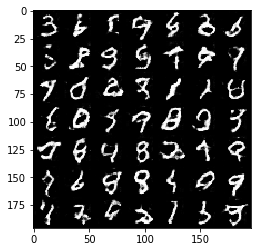

Epoch 2/2... Discriminator Loss: 2.1884... Generator Loss: 0.5242
Epoch 2/2... Discriminator Loss: 2.1379... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 2.2476... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 2.1789... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 2.5458... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 2.3209... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 3.4259... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 1.6454... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.6626... Generator Loss: 0.5038
Epoch 2/2... Discriminator Loss: 1.8410... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.9128... Generator Loss: 0.4769
Epoch 2/2... Discriminator Loss: 2.1592... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 2.0682... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 2.2325... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.9201... Generator Loss: 0.7014
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 2.4427... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 2.0562... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 1.9864... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 2.4369... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 2.0625... Generator Loss: 0.4272
Epoch 2/2... Discriminator Loss: 2.3285... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 2.5237... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 2.0371... Generator Loss: 0.4494
Epoch 2/2... Discriminator Loss: 2.0417... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 2.1778... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 1.9853... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 2.1271... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 2.2223... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 2.5382... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 2.1780... Generator Loss: 0.3870
Epoch 2/2.

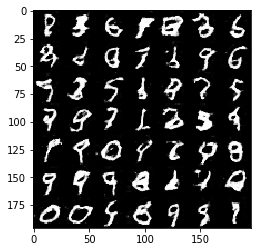

Epoch 2/2... Discriminator Loss: 2.0306... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 2.2663... Generator Loss: 0.4923
Epoch 2/2... Discriminator Loss: 2.5995... Generator Loss: 0.6265
Epoch 2/2... Discriminator Loss: 2.4616... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 2.1054... Generator Loss: 0.3102
Epoch 2/2... Discriminator Loss: 1.9105... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 2.5642... Generator Loss: 0.5273
Epoch 2/2... Discriminator Loss: 2.2981... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 2.4708... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 2.4951... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 2.0779... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 2.4159... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 1.9966... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 2.0336... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 2.1880... Generator Loss: 0.2820
Epoch 2/2.

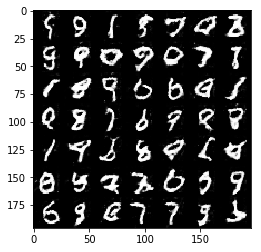

Epoch 2/2... Discriminator Loss: 2.3321... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 2.3566... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 2.2588... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 2.2503... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 2.3851... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 2.9203... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 2.0398... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 2.0119... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 2.5110... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 2.4264... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 2.1941... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 2.1452... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 2.6972... Generator Loss: 0.5459
Epoch 2/2... Discriminator Loss: 2.8167... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 3.1958... Generator Loss: 0.7931
Epoch 2/2.

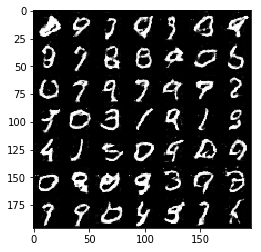

Epoch 2/2... Discriminator Loss: 2.7230... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 2.2356... Generator Loss: 0.4320
Epoch 2/2... Discriminator Loss: 2.6000... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 2.5045... Generator Loss: 0.8239
Epoch 2/2... Discriminator Loss: 2.3816... Generator Loss: 0.4703
Epoch 2/2... Discriminator Loss: 2.3344... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 2.2941... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 2.4997... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 2.5403... Generator Loss: 0.4153
Epoch 2/2... Discriminator Loss: 2.8695... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 3.1844... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 3.8706... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 2.5146... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 3.4647... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 2.4825... Generator Loss: 0.3888
Epoch 2/2.

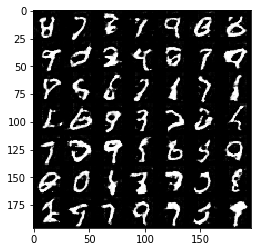

Epoch 2/2... Discriminator Loss: 2.4589... Generator Loss: 0.4289
Epoch 2/2... Discriminator Loss: 2.7498... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 2.5340... Generator Loss: 0.6081
Epoch 2/2... Discriminator Loss: 2.9104... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 2.7946... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 4.1380... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 2.1927... Generator Loss: 0.2409
Epoch 2/2... Discriminator Loss: 3.7722... Generator Loss: 1.8251
Epoch 2/2... Discriminator Loss: 2.8454... Generator Loss: 0.4500
Epoch 2/2... Discriminator Loss: 1.5336... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.7649... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.6237... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.9977... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 2.0180... Generator Loss: 0.5311
Epoch 2/2.

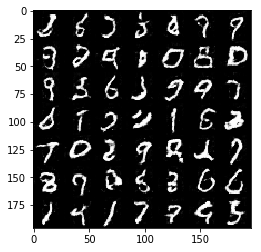

Epoch 2/2... Discriminator Loss: 2.4561... Generator Loss: 0.4194
Epoch 2/2... Discriminator Loss: 2.4285... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 2.9021... Generator Loss: 0.4854
Epoch 2/2... Discriminator Loss: 2.8463... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 3.1912... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 2.5257... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 2.4647... Generator Loss: 0.5795
Epoch 2/2... Discriminator Loss: 2.5460... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 2.2619... Generator Loss: 0.4092
Epoch 2/2... Discriminator Loss: 2.0672... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 3.0262... Generator Loss: 0.2187
Epoch 2/2... Discriminator Loss: 2.5165... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 3.1501... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 2.4751... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 2.9350... Generator Loss: 0.5808
Epoch 2/2.

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 3, 3, 512)
(?, 6, 6, 256)
(?, 13, 13, 128)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Epoch 1/1... Discriminator Loss: 4.4394... Generator Loss: 0.0158
Epoch 1/1... Discriminator Loss: 3.9823... Generator Loss: 0.0219
Epoch 1/1... Discriminator Loss: 3.9913... Generator Loss: 0.0227
Epoch 1/1... Discriminator Loss: 3.8679... Generator Loss: 0.0287
Epoch 1/1... Discriminator Loss: 3.8489... Generator Loss: 0.0294
Epoch 1/1... Discriminator Loss: 3.9124... Generator Loss: 0.0276
Epoch 1/1... Discriminator Loss: 4.0548... Generator Loss: 0.0245
Epoch 1/1... Discriminator Loss: 3.5133... Generator Loss: 0.0438
Epoch 1/1... Discriminator Loss: 3.3961... Generator Loss: 0.0495
Epoch 1/1... Discriminator Loss: 3.5010... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 3.4058... Generator Loss: 0.0525
Epoch 1/1... Discriminator Loss: 3.1258... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 3.1101... Generator Loss: 0.0856
Epoch 1/1

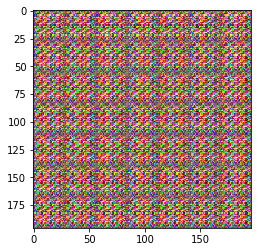

Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 0.8889
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.3748
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 1.4608
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 1.6517
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 1.7130
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 1.4123
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.9845... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.8703... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.8319... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.9849... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.8989... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.9940... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.9398... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 2.0877... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 2.0329... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 2.1131... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.8483... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.9684... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.8327... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.8195
Epoch 1/1.

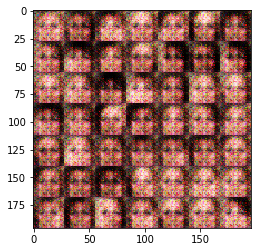

Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.9331... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.8508... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.9054... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.8088... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.9000... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.7911... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.9876... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.9607... Generator Loss: 0.6229
Epoch 1/1.

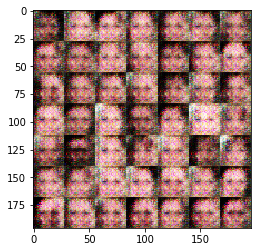

Epoch 1/1... Discriminator Loss: 1.7564... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.8523... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.8443... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.9106... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.9264... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.9661... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.9610... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.8699... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 2.0086... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.9361... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.9295... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.8882... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.8385... Generator Loss: 0.6364
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.8494... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.9334... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.9253... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 2.0067... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.9335... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.9437... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.9524... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.8310... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.7838... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.9580... Generator Loss: 0.5929
Epoch 1/1.

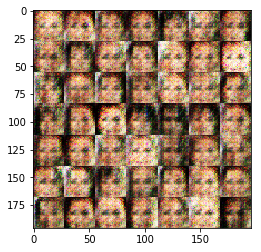

Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 2.0099... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 2.0747... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.9014... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.8304... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.8612... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.9634... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.8073... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.9383... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.8340... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.9817... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.8714... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.8412... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.8663... Generator Loss: 0.5884
Epoch 1/1.

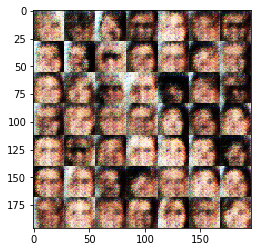

Epoch 1/1... Discriminator Loss: 1.7588... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.8427... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.8642... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.8096... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.8852... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.8487... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.9295... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.8619... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.9529... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.7808... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.8961... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.9604... Generator Loss: 0.5792
Epoch 1/1.

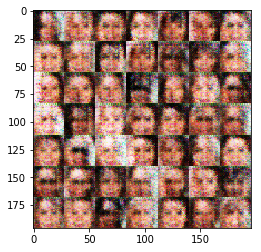

Epoch 1/1... Discriminator Loss: 1.8611... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.8520... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.8768... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.8368... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.8514... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.8795... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.8264... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.8598... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.6318
Epoch 1/1.

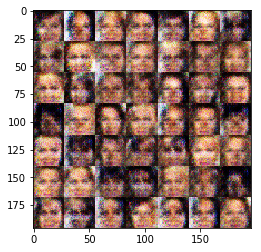

Epoch 1/1... Discriminator Loss: 1.8359... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.8404... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.8894... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.7754... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.8241... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.8808... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.8704... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.7551... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.9656... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.8033... Generator Loss: 0.6455
Epoch 1/1.

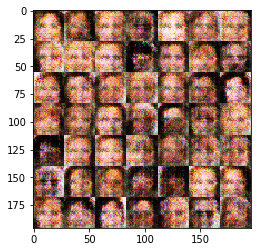

Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.8166... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.8633... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.8306... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.8852... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.8830... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.8231... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.8855... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.8827... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.7852... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.8558... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.9267... Generator Loss: 0.5972
Epoch 1/1.

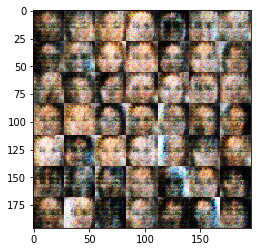

Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.7454... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.7801... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.7188... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.7718... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.6968... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.7902... Generator Loss: 0.6039
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.7452... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.7610... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.7327... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.6781... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.7261... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 0.6855
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.7218... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.7674... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.7774... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.6626
Epoch 1/1.

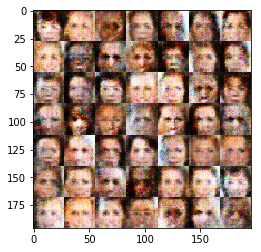

Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.7033... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.6906... Generator Loss: 0.6273
Epoch 1/1.

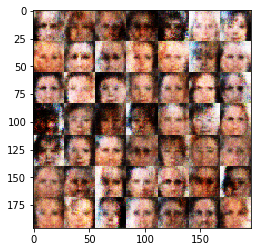

Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.6295... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.6375
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.6412... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.6786
Epoch 1/1.

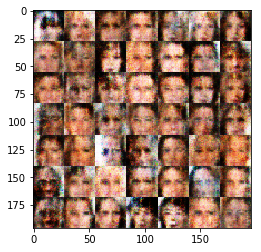

Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.6455
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7135
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.6221
Epoch 1/1.

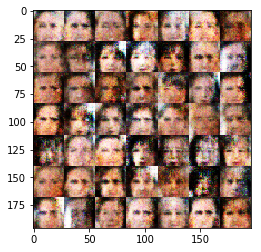

Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.6266
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.6367
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6756
Epoch 1/1.

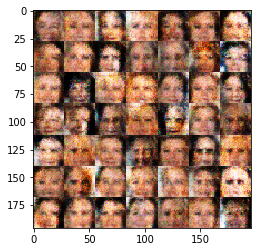

Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6750
Epoch 1/1.

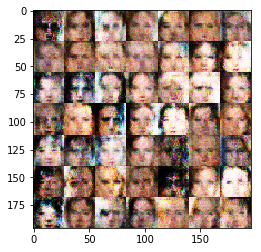

Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6580
Epoch 1/1.

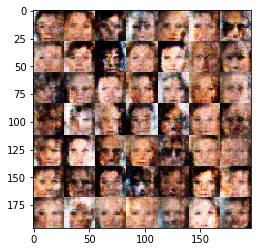

Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6594
Epoch 1/1.

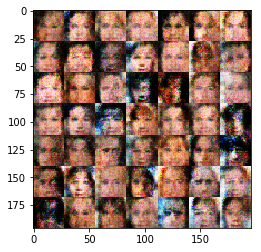

Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6676
Epoch 1/1.

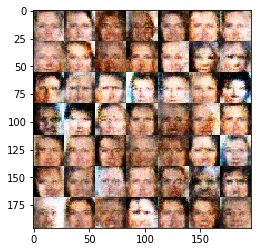

Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.6573
Epoch 1/1.

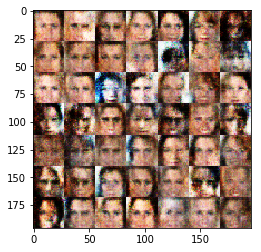

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6498
Epoch 1/1.

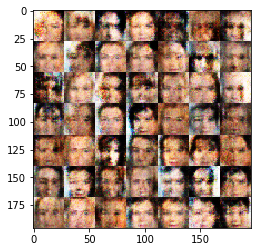

Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6457
Epoch 1/1.

In [26]:
batch_size = 64
z_dim = 150
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.